<a href="https://colab.research.google.com/github/rrsguim/PhD_Economics/blob/master/TL4BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

------------------------------------------------------------------------------------------------------
Copyright (c) 2020 Rafael Guimaraes

This is part of my doctoral thesis in Economics

Universidade Federal do Rio Grande do Sul / Brazil

University of California Riverside / US

See full material at https://github.com/rrsguim/PhD_Economics

The code below, under the Apache License, is an adaptation of

*Classification on imbalanced data*, and 

*Introduction to the Keras Tuner*

Copyright 2020 The TensorFlow Authors

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

https://www.tensorflow.org/tutorials/keras/keras_tuner

-------------------------------------------------------------------------

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [3]:
!pip install -U keras-tuner

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [4]:
import tensorflow as tf
from tensorflow import keras

import IPython

import kerastuner as kt
from kerastuner import RandomSearch

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Deep Learning | United States

In [0]:
file = tf.keras.utils
raw_data = pd.read_csv('https://raw.githubusercontent.com/rrsguim/PhD_Economics/master/NN4BC/TL4BC_US_data.csv')

In [0]:
raw_data.index = raw_data['DATE']
drop_DATE = raw_data.pop('DATE')
raw_data.index = pd.to_datetime(raw_data.index,infer_datetime_format=True)
raw_data.index = raw_data.index.to_period("Q")

In [8]:
neg, pos = np.bincount(raw_data['NBER'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 212
    Positive: 27 (12.74% of total)



In [0]:
log_data = raw_data.copy()

log_data['GDP'] = np.log(log_data['GDP'])
log_data['Income'] = np.log(log_data['Income'])
log_data['Employment'] = np.log(log_data['Employment'])
log_data['Industry'] = np.log(log_data['Industry'])
log_data['Sales'] = np.log(log_data['Sales'])

In [0]:
log_1df = log_data.copy()

log_1df['GDP'] = log_data['GDP'] - log_data['GDP'].shift(1)
log_1df['Income'] = log_data['Income'] - log_data['Income'].shift(1)
log_1df['Employment'] = log_data['Employment'] - log_data['Employment'].shift(1)
log_1df['Industry'] = log_data['Industry'] - log_data['Industry'].shift(1)
log_1df['Sales'] = log_data['Sales'] - log_data['Sales'].shift(1)

In [11]:
log_1df = log_1df[1:]
log_1df.tail()

,GDP,Income,Employment,Industry,Sales,NBER
DATE,,,,,,
2018Q4,0.002710,0.005645,0.004112,0.009481,0.003436,0
2019Q1,0.007623,0.009776,0.001403,-0.004879,0.014956,0
2019Q2,0.004985,0.004228,0.000904,-0.005700,-0.005293,0
2019Q3,0.005204,0.001736,0.007021,0.002808,0.009172,0
2019Q4,0.005261,0.005844,0.001715,0.000877,0.000543,0


In [0]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(log_1df, test_size=0.2)  
train_df, val_df = train_test_split(train_df, test_size=0.2)  

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('NBER'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('NBER'))
test_labels = np.array(test_df.pop('NBER'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [0]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


In [0]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = train_df.columns)

In [0]:
initial_bias = np.log([pos/neg])

In [0]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


def make_model(hp, metrics = METRICS, output_bias = initial_bias):  
  output_bias = tf.keras.initializers.Constant(output_bias)

  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(train_features.shape[-1],))) #CHANGE FROM DENSE TO FLATTEN. MUST CHECK IT
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 16-256
  hp_units = hp.Int('units', min_value = 16, max_value = 256, step = 16)
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
  
  model.add(keras.layers.Dropout(0.5)) # To prevent overfiting

  model.add(keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)) # Output layer

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.BinaryCrossentropy(), 
                metrics = metrics)
  
  return model


In [17]:
tuner = kt.Hyperband(make_model,
                     kt.Objective('val_auc', direction='max'), # Maximizes Area Under the ROC Curve
                     max_epochs = 10,
                     factor = 3,
#                     directory = 'my_dir',
                     project_name = 'TL4BC')

INFO:tensorflow:Reloading Oracle from existing project ./TL4BC/oracle.json
INFO:tensorflow:Reloading Tuner from ./TL4BC/tuner0.json


Before running the hyperparameter search, define a callback to clear the training outputs at the end of every training step.

In [0]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

Run the hyperparameter search. The arguments for the search method are the same as those used for tf.keras.model.fit in addition to the callback above.

In [19]:
tuner.search(train_features, train_labels,
             epochs=150,
             validation_data=(val_features, val_labels), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 256 and the optimal learning rate for the optimizer
is 0.001.



In [0]:
#tuner.results_summary()

Retrain the model with the optimal hyperparameters from the search.

In [21]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
model.fit(train_features, train_labels,
             epochs=150,
             validation_data=(val_features, val_labels))

Epoch 1/150
5/5 [==============================] - 1s 177ms/step - loss: 0.3708 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 115.0000 - fn: 19.0000 - accuracy: 0.8582 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8137 - val_loss: 0.2734 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 30.0000 - val_fn: 4.0000 - val_accuracy: 0.8824 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 1.0000
Epoch 2/150
5/5 [==============================] - 0s 11ms/step - loss: 0.3227 - tp: 1.0000 - fp: 0.0000e+00 - tn: 115.0000 - fn: 18.0000 - accuracy: 0.8657 - precision: 1.0000 - recall: 0.0526 - auc: 0.9465 - val_loss: 0.2356 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 30.0000 - val_fn: 3.0000 - val_accuracy: 0.9118 - val_precision: 1.0000 - val_recall: 0.2500 - val_auc: 1.0000
Epoch 3/150
5/5 [==============================] - 0s 12ms/step - loss: 0.2850 - tp: 1.0000 - fp: 0.0000e+00 - tn: 115.0000 - fn: 18.0000 - accuracy: 0.8657 - precision: 1.0000 - recall: 0.0526 - auc: 0.

In [0]:
dataset_copy = log_1df
y = dataset_copy.pop('NBER')
x = dataset_copy

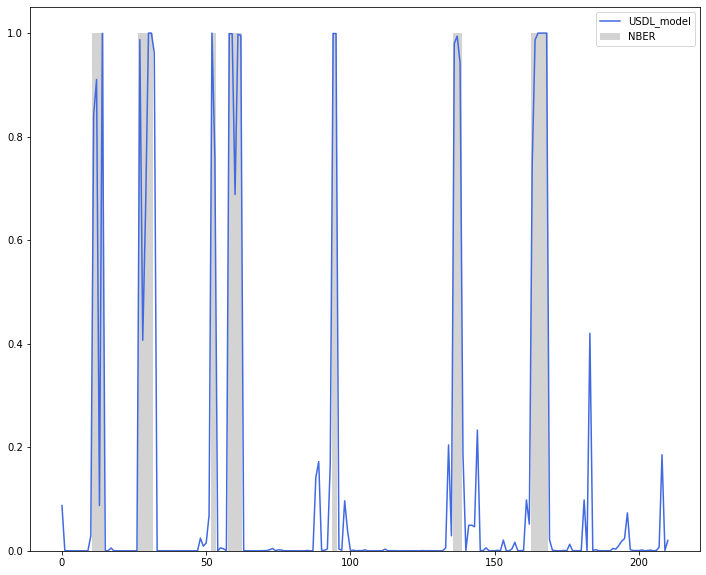

In [23]:
USDL_model = model.predict(scaler.fit_transform(x)) #fit_transform or transform ???
#USDL_model = [np.round(x) for x in DL_model]
time_axis = range(0,y.shape[0]) #log_df_date[1:]
plt.bar(time_axis, y.T, width=1, linewidth=1, align='center', color="lightgray", label='NBER') #****check width and linewidht
plt.plot(time_axis, USDL_model, 'b-', color="royalblue", label='USDL_model') #model
plt.legend()
plt.show()

#Transfer Learning | Brazil and EURO

##Brazil

In [0]:
BR_raw_data = pd.read_csv('https://raw.githubusercontent.com/rrsguim/PhD_Economics/master/NN4BC/TL4BC_Brazil_data.csv')

In [0]:
BR_raw_data.index = BR_raw_data['DATE']
drop_DATE = BR_raw_data.pop('DATE')
BR_raw_data.index = pd.to_datetime(BR_raw_data.index,infer_datetime_format=True)
BR_raw_data.index = BR_raw_data.index.to_period("Q")


In [0]:
BR_log_data = BR_raw_data.copy()

BR_log_data['GDP'] = np.log(BR_log_data['GDP'])
BR_log_data['Income'] = np.log(BR_log_data['Income'])
BR_log_data['Employment'] = np.log(BR_log_data['Employment'])
BR_log_data['Industry'] = np.log(BR_log_data['Industry'])
BR_log_data['Sales'] = np.log(BR_log_data['Sales'])

In [0]:
BR_log_1df = BR_log_data.copy()

BR_log_1df['GDP'] = BR_log_data['GDP'] - BR_log_data['GDP'].shift(1)
BR_log_1df['Income'] = BR_log_data['Income'] - BR_log_data['Income'].shift(1)
BR_log_1df['Employment'] = BR_log_data['Employment'] - BR_log_data['Employment'].shift(1)
BR_log_1df['Industry'] = BR_log_data['Industry'] - BR_log_data['Industry'].shift(1)
BR_log_1df['Sales'] = BR_log_data['Sales'] - BR_log_data['Sales'].shift(1)

In [0]:
BR_dataset_copy = BR_log_1df
yBR = BR_dataset_copy.pop('CODACE')
xBR = BR_dataset_copy

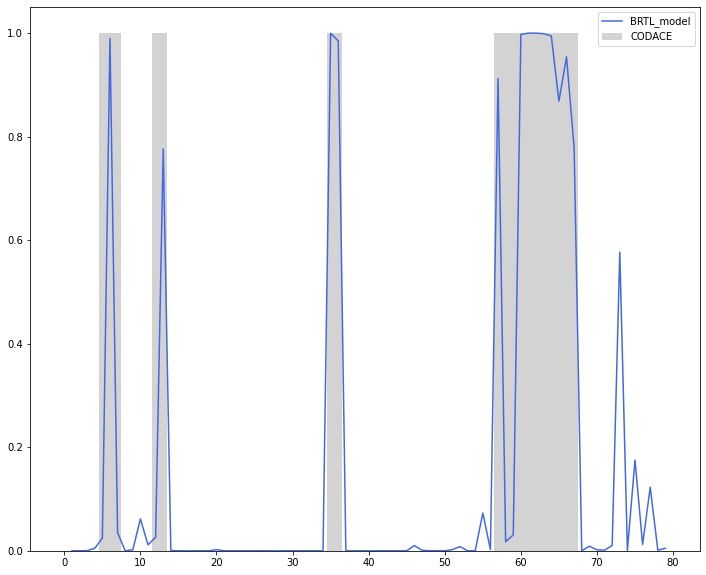

In [29]:
BRTL_model = model.predict(scaler.fit_transform(xBR)) #fit_transform or transform ???
#BRTL_model = [np.round(xBR) for x in BRTL_model]
time_axis = range(0,yBR.shape[0])
plt.bar(time_axis, yBR.T, width=1, linewidth=1, align='center', color="lightgray", label='CODACE') #****check width and linewidht
plt.plot(time_axis, BRTL_model, 'b-', color="royalblue", label='BRTL_model') #model
plt.legend()
plt.show()

##EURO

In [0]:
EURO_raw_data = pd.read_csv('https://raw.githubusercontent.com/rrsguim/PhD_Economics/master/NN4BC/TL4BC_Euro_data_2005.csv')

In [0]:
EURO_raw_data.index = EURO_raw_data['DATE']
drop_DATE = EURO_raw_data.pop('DATE')
EURO_raw_data.index = pd.to_datetime(EURO_raw_data.index,infer_datetime_format=True)
EURO_raw_data.index = EURO_raw_data.index.to_period("Q")

In [0]:
EURO_log_data = EURO_raw_data.copy()

EURO_log_data['GDP'] = np.log(EURO_log_data['GDP'])
EURO_log_data['Income'] = np.log(EURO_log_data['Income'])
EURO_log_data['Employment'] = np.log(EURO_log_data['Employment'])
EURO_log_data['Industry'] = np.log(EURO_log_data['Industry'])
EURO_log_data['Sales'] = np.log(EURO_log_data['Sales'])

In [0]:
EURO_log_1df = EURO_log_data.copy()

EURO_log_1df['GDP'] = EURO_log_data['GDP'] - EURO_log_data['GDP'].shift(1)
EURO_log_1df['Income'] = EURO_log_data['Income'] - EURO_log_data['Income'].shift(1)
EURO_log_1df['Employment'] = EURO_log_data['Employment'] - EURO_log_data['Employment'].shift(1)
EURO_log_1df['Industry'] = EURO_log_data['Industry'] - EURO_log_data['Industry'].shift(1)
EURO_log_1df['Sales'] = EURO_log_data['Sales'] - EURO_log_data['Sales'].shift(1)

In [0]:
EURO_dataset_copy = EURO_log_1df
yEURO = EURO_dataset_copy.pop('CEPR')
xEURO = EURO_dataset_copy

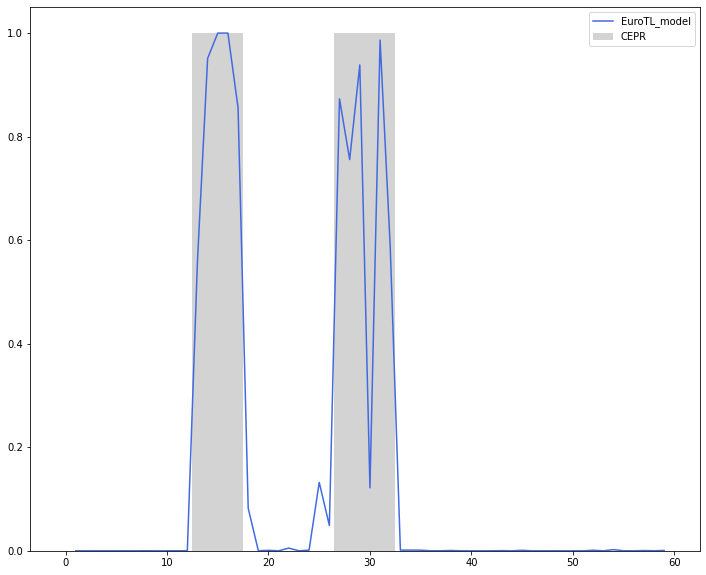

In [35]:
EuroTL_model = model.predict(scaler.fit_transform(xEURO)) #fit_transform or transform ???
#EuroTL_model = [np.round(xEURO) for x in EuroTL_model]
time_axis = range(0,yEURO.shape[0])
plt.bar(time_axis, yEURO.T, width=1, linewidth=1, align='center', color="lightgray", label='CEPR') #****check width and linewidht
plt.plot(time_axis, EuroTL_model, 'b-', color="royalblue", label='EuroTL_model') #model
plt.legend()
plt.show()

#Export classification data

In [0]:
import datetime
now = datetime.datetime.now().strftime("%Y%m%d_%Hh%M")

In [0]:
TL4BC_USDL = pd.DataFrame(y)
TL4BC_USDL['USDL_model'] = np.array(USDL_model)

a1 = np.asarray(TL4BC_USDL)
np.savetxt("TL4BC_USDL_output_"+now+".csv", a1, delimiter=",")

In [0]:
TL4BC_BRTL = pd.DataFrame(yBR)
TL4BC_BRTL['BRTL_model'] = np.array(BRTL_model)

a2 = np.asarray(TL4BC_BRTL)
np.savetxt("TL4BC_BRTL_output_"+now+".csv", a2, delimiter=",")

In [0]:
TL4BC_EuroTL = pd.DataFrame(yEURO)
TL4BC_EuroTL['EuroTL_model'] = np.array(EuroTL_model)

a3 = np.asarray(TL4BC_EuroTL)
np.savetxt("TL4BC_EuroTL_output_"+now+".csv", a3, delimiter=",")